In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()  # kaggle.json dosyasını yükle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip gtsrb-german-traffic-sign.zip -d gtsrb

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: gtsrb/train/5/00005_00053_00010.png  
  inflating: gtsrb/train/5/00005_00053_00011.png  
  inflating: gtsrb/train/5/00005_00053_00012.png  
  inflating: gtsrb/train/5/00005_00053_00013.png  
  inflating: gtsrb/train/5/00005_00053_00014.png  
  inflating: gtsrb/train/5/00005_00053_00015.png  
  inflating: gtsrb/train/5/00005_00053_00016.png  
  inflating: gtsrb/train/5/00005_00053_00017.png  
  inflating: gtsrb/train/5/00005_00053_00018.png  
  inflating: gtsrb/train/5/00005_00053_00019.png  
  inflating: gtsrb/train/5/00005_00053_00020.png  
  inflating: gtsrb/train/5/00005_00053_00021.png  
  inflating: gtsrb/train/5/00005_00053_00022.png  
  inflating: gtsrb/train/5/00005_00053_00023.png  
  inflating: gtsrb/train/5/00005_00053_00024.png  
  inflating: gtsrb/train/5/00005_00053_00025.png  
  inflating: gtsrb/train/5/00005_00053_00026.png  
  inflating: gtsrb/train/5/00005_00053_00027.png  
  inflating: gtsrb/train/5/00005_00

A.1.1 Inspect the data layout

In [ ]:
from pathlib import Path
path = Path('/content/gtsrb/Train')
folders = list(path.ls())
print(f"Number of classes: {len(folders)}")
print(f"First few class folders: {[f.name for f in folders[:5]]}")

Number of classes: 43
First few class folders: ['16', '15', '18', '12', '6']


A.2.1 Define the blocks

A.2.2 Define the means of getting data into DataBlock

A.2.3 Define how to get the attributes

A.2.4 Define data transformations

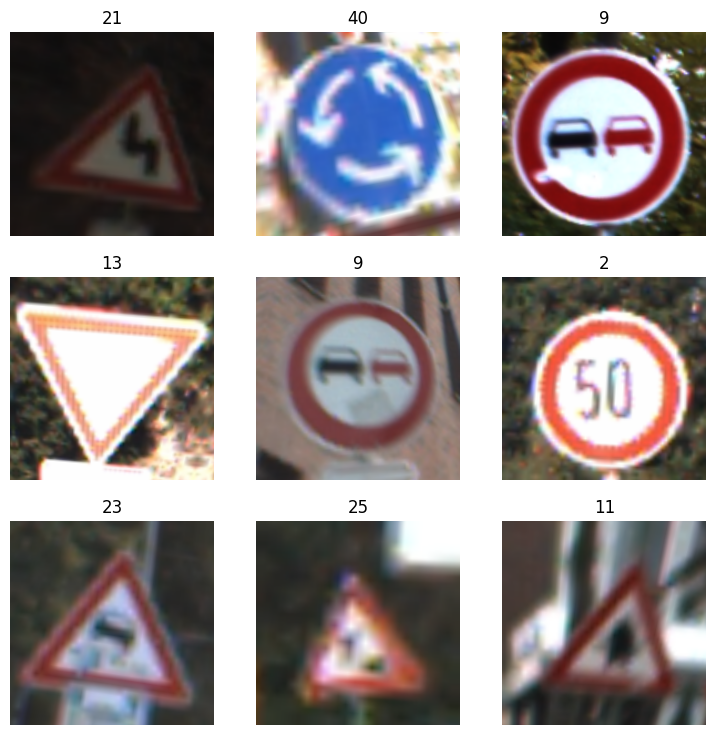

In [ ]:
from fastai.vision.all import *

# Eğitim verisinin bulunduğu klasör
path = Path('/content/gtsrb/Train')

# DataBlock tanımı
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,  # klasör adını etiket olarak al
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(128),  # Presizing
    batch_tfms=aug_transforms(size=224)  # Batch augmentations
)

# DataLoaders oluştur
dls = dblock.dataloaders(path, bs=64)

# Batch görüntüle
dls.show_batch(max_n=9)

A.3.1 show_batch()

A.3.2 Check the labels

A.3.3 summary()

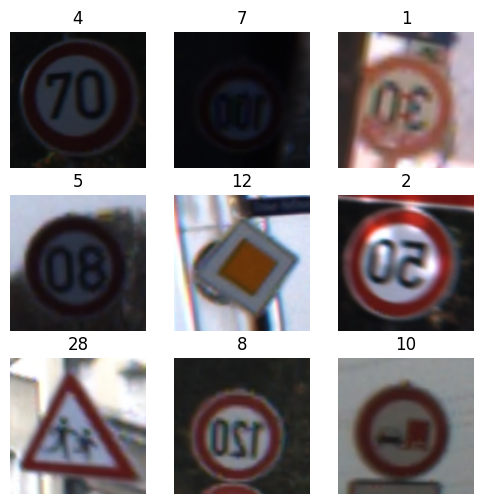

In [ ]:
dls.show_batch(max_n=9, figsize=(6,6))

A.3.2 Check the labels



In [ ]:
print(dls.vocab)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


A.3.3 summary()

In [ ]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 39209 items
2 datasets of sizes 31368,7841
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/gtsrb/Train/25/00025_00002_00025.png
    applying PILBase.create gives
      PILImage mode=RGB size=103x95
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/gtsrb/Train/25/00025_00002_00025.png
    applying parent_label gives
      25
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(18)

Final sample: (PILImage mode=RGB size=103x95, TensorCategory(18))


Found 39209 items
2 datasets of sizes 31368,7841
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Re

A.4.1 Create a benchmark

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 179MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.856790,0.452003,0.846831,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.168827,0.093103,0.967224,00:34
1,0.076649,0.071902,0.976534,00:34
2,0.034089,0.013335,0.995536,00:34
3,0.008056,0.006844,0.998215,00:34
4,0.003903,0.004800,0.998470,00:34


A.4.2 Interpret the model

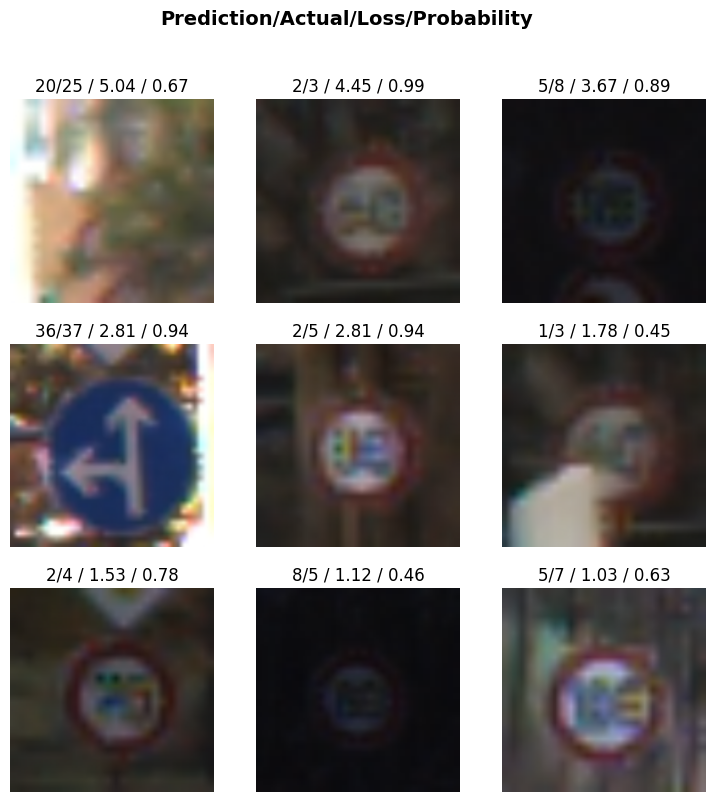

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, nrows=3)

A.4.3 Confusion matrix

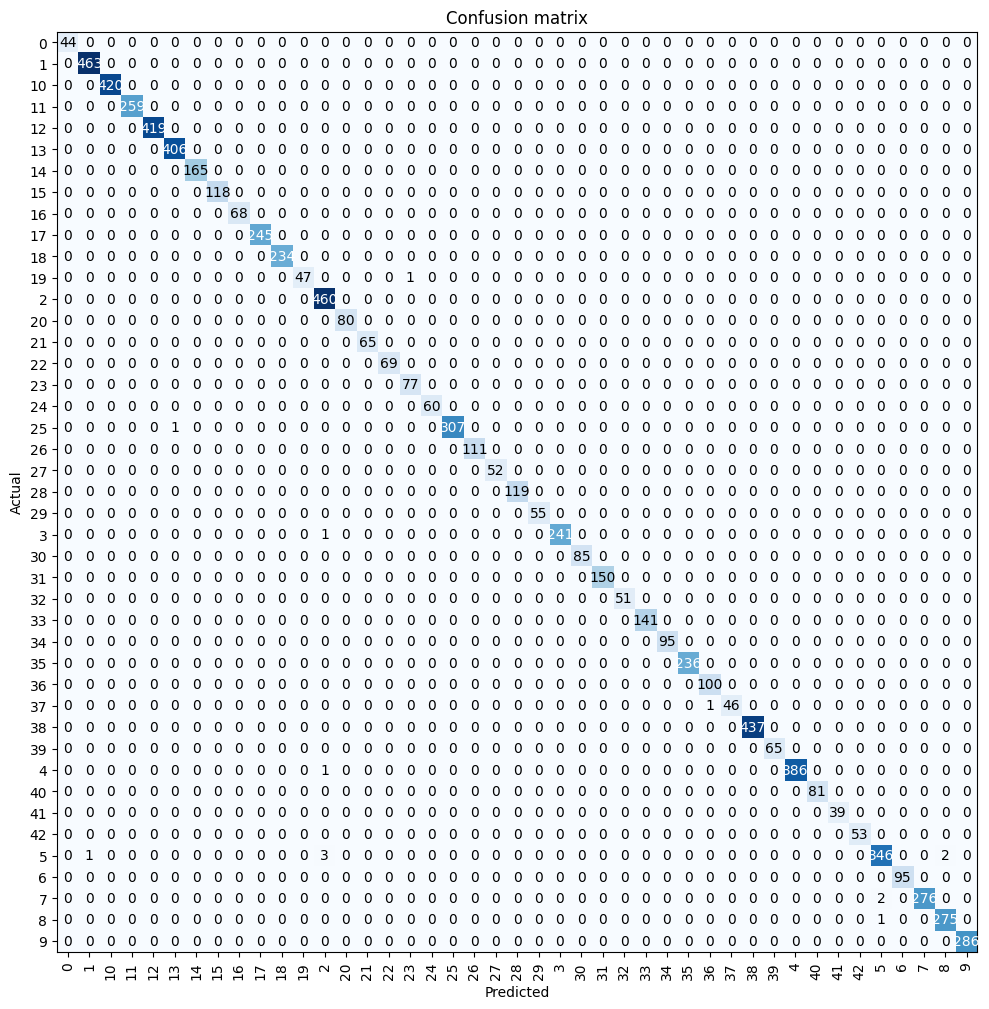

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10))

 B.1. Learning Rate Finder

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s]


Büyük L.R

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,3.364685,8.542341,0.278663,00:24
1,2.835638,23.441654,0.659865,00:24
2,1.426608,6.116822,0.832164,00:24
3,0.525880,3.756613,0.909960,00:24
4,0.329265,0.443330,0.942609,00:24


Küçük L.R

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(5, lr_max=1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,5.528780,4.473540,0.029205,00:24
1,5.398770,4.362749,0.032521,00:24
2,5.374418,4.323816,0.036602,00:24
3,5.306534,4.311662,0.038260,00:24
4,5.294889,4.283899,0.038771,00:24


B.2. Finder Algorithm

In [ ]:
from torch.optim import SGD
import matplotlib.pyplot as plt

lrs = []
losses = []

learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.model.train()
learn.model = learn.model.to('cuda')  # ✅ Model GPU'ya

lr = 1e-7
xb, yb = dls.one_batch()
xb, yb = xb.to('cuda'), yb.to('cuda')  # ✅ Veriler GPU'ya

for i in range(100):
    opt = SGD(learn.model.parameters(), lr=lr)
    opt.zero_grad()

    preds = learn.model(xb)
    loss = CrossEntropyLossFlat()(preds, yb)
    loss.backward()
    opt.step()

    lrs.append(lr)
    losses.append(loss.item())

    lr *= 1.4

    if i > 5 and loss.item() > 10:
        break

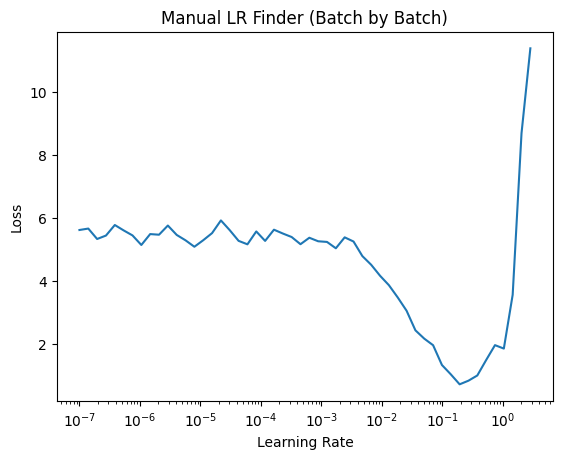

In [ ]:
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Manual LR Finder (Batch by Batch)")
plt.show()

SuggestedLRs(valley=0.0010000000474974513, slide=0.0030199517495930195, steep=0.005248074419796467)

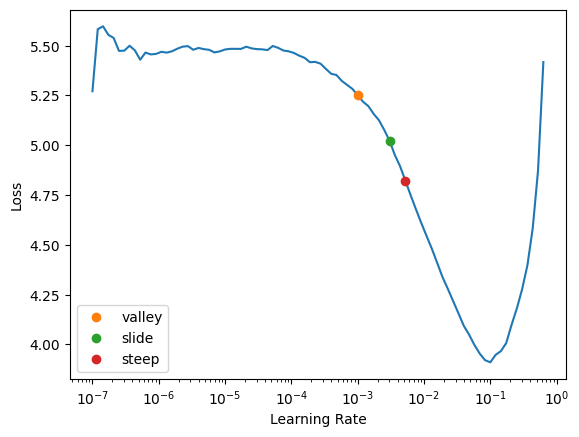

In [ ]:
from fastai.callback.schedule import valley, slide, steep
learn.lr_find(suggest_funcs=[valley, slide, steep])

In [ ]:
lr = slice(1e-4, 1e-2)

B.3. Transfer Learning (Freeze / Unfreeze)

In [ ]:
learn.freeze()
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.465987,0.204029,0.930749,00:28
1,0.151142,0.079860,0.971177,00:28
2,0.106323,0.049753,0.983548,00:28


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.377873,0.699095,0.849254,00:34
1,0.152207,0.093435,0.969137,00:34
2,0.087473,0.039291,0.987119,00:34
3,0.025728,0.011229,0.995791,00:34
4,0.011574,0.005768,0.998087,00:34


B.4. Discriminative Learning Rates

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.102816,0.036663,0.986226,00:34
1,0.072916,0.040361,0.985716,00:34
2,0.042929,0.021678,0.993113,00:34
3,0.008953,0.002905,0.999107,00:34
4,0.002112,0.001891,0.999617,00:34


 B.6. Model Capacity

In [ ]:
# 1. DataLoaders
dls = dblock.dataloaders(path, bs=32)

# 2. Modeli tanımla (fp16 YOK!)
learn = vision_learner(dls, resnet50, metrics=accuracy)

# 3. Eğitim stratejisi
learn.freeze()
learn.fit_one_cycle(3, lr_max=1e-3)

learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-4, 1e-2))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.718202,0.336803,0.887514,00:59
1,0.243615,0.108590,0.964800,00:59
2,0.161031,0.081867,0.971177,00:59


epoch,train_loss,valid_loss,accuracy,time
0,0.487989,0.449042,0.897207,01:08
1,0.181429,0.121379,0.959316,01:09
2,0.095192,0.036747,0.985589,01:09
3,0.022349,0.009588,0.997322,01:09
4,0.009184,0.004171,0.998980,01:09


In [ ]:

# 4. Export et
learn.export('gtsrb_model_cpu.pkl')

B.7. Weight Initialization

In [ ]:
from fastai.vision.all import *

path = Path('/content/gtsrb/Train')  # senin verinin olduğu klasör

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(64),            # küçük boyut, hızlı eğitim için
    batch_tfms=aug_transforms(size=64)
)

dls = dblock.dataloaders(path, bs=64)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init_fn

class SimpleCNN(nn.Module):
    def __init__(self, init_type='kaiming'):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*16*16, 128)
        self.fc2 = nn.Linear(128, 43)  # GTSRB: 43 sınıf

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'kaiming':
            init_fn.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
            init_fn.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
            init_fn.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
            init_fn.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        elif init_type == 'xavier':
            init_fn.xavier_uniform_(self.conv1.weight)
            init_fn.xavier_uniform_(self.conv2.weight)
            init_fn.xavier_uniform_(self.fc1.weight)
            init_fn.xavier_uniform_(self.fc2.weight)
        elif init_type == 'orthogonal':
            init_fn.orthogonal_(self.conv1.weight)
            init_fn.orthogonal_(self.conv2.weight)
            init_fn.orthogonal_(self.fc1.weight)
            init_fn.orthogonal_(self.fc2.weight)

        for m in [self.conv1, self.conv2, self.fc1, self.fc2]:
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
def train_model(init_type='kaiming'):
    model = SimpleCNN(init_type)
    learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
    learn.fit(5)
    return learn

In [ ]:
results = {}

for init_type in ['kaiming', 'xavier', 'orthogonal']:
    print(f"\nTraining with {init_type} initialization")
    learn = train_model(init_type)
    acc = learn.validate()[1]
    results[init_type] = acc

print("\n--- Accuracy Results ---")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


Training with kaiming initialization


epoch,train_loss,valid_loss,accuracy,time
0,1.723790,1.348070,0.595842,00:13
1,1.198973,0.839246,0.742635,00:13
2,0.945614,0.647159,0.805382,00:13
3,0.796644,0.505701,0.844408,00:13
4,0.708905,0.419527,0.872083,00:13



Training with xavier initialization


epoch,train_loss,valid_loss,accuracy,time
0,1.393502,0.987841,0.696595,00:13
1,0.909776,0.546349,0.833185,00:13
2,0.700290,0.472251,0.843005,00:13
3,0.597904,0.329095,0.897845,00:13
4,0.506863,0.266481,0.916975,00:13



Training with orthogonal initialization


epoch,train_loss,valid_loss,accuracy,time
0,1.427263,1.034066,0.679888,00:13
1,1.000493,0.635408,0.798368,00:13
2,0.771359,0.427157,0.863538,00:13
3,0.641311,0.363827,0.884836,00:13
4,0.535500,0.269622,0.915572,00:13



--- Accuracy Results ---
kaiming: 0.8721
xavier: 0.9170
orthogonal: 0.9156


Transfer Learning Modeli Weight Değiştirme B7.5

In [ ]:
learn = vision_learner(dls, resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


In [ ]:
import torch.nn as nn
import torch.nn.init as init_fn

def custom_weight_init(m):
    if isinstance(m, nn.Linear):
        if m.weight is not None:
            nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
learn.model[1].apply(custom_weight_init)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=43, bias=False)
)

In [ ]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.570477,1.120681,0.664966,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.486317,0.285308,0.909705,00:34
1,0.198844,0.106941,0.963142,00:34
2,0.087447,0.039981,0.986991,00:34
3,0.056895,0.024432,0.992093,00:34
4,0.037953,0.019901,0.994516,00:34


In [ ]:
acc = learn.validate()[1]
print(f"Accuracy with Xavier initialization on head: {acc:.4f}")

Accuracy with Xavier initialization on head: 0.9945


In [ ]:
import torch.nn as nn
import torch.nn.init as init

def kaiming_init_head(learn):
    for m in learn.model.modules():
        if isinstance(m, nn.Linear):
            if m.weight is not None:
                init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [ ]:
learn = vision_learner(dls, resnet50, metrics=accuracy)
kaiming_init_head(learn)

In [ ]:
learn.fine_tune(5)
acc = learn.validate()[1]
print(f"Kaiming init (head only) accuracy: {acc:.4f}")

epoch,train_loss,valid_loss,accuracy,time
0,1.634606,1.062008,0.678230,00:28


epoch,train_loss,valid_loss,accuracy,time
0,0.540388,0.274569,0.909068,00:34
1,0.210741,0.093340,0.969647,00:34
2,0.105137,0.040473,0.985206,00:34
3,0.045013,0.021345,0.992986,00:34
4,0.042129,0.016442,0.994388,00:34


Kaiming init (head only) accuracy: 0.9944
